In [1]:
#import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pandas as pd
%matplotlib inline

In [2]:
#define date range
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2021, 5, 31)
years = (end - start).days / 365.25

In [3]:
#define starting variables
symbols = ["^GSPC"]#, "^FTSE", "SPY", "^DJI", "^IXIC", "^RUT", "^N225"]
systems = ["RSI4"]#, "RSI14", "BuyHold"]
starting_balance = 10000
slow_ma = 200
fast_ma = 5
rsi_period = 4
rsi_thresh = 33

In [4]:
def calculate_inputs(df, s):
    #calculate inputs required for system
    
    #calculate moving averages
    df["Fast_MA"] = df.Close.rolling(window = fast_ma).mean()
    df["Slow_MA"] = df.Close.rolling(window = slow_ma).mean()
    
    #daily change
    df["Change"] = df.Close.diff()
    #separate into up and down days
    df["Gain"] = df.Change.clip(lower = 0)
    df["Loss"] = -1 * df.Change.clip(upper = 0)
    
    #average gains with EMA smoothing (Wilder)
    if s.startswith("RSI"): 
        rsi_period = int(s[3:])
        df[f"{s}Avg_Gain"] = ((df.Gain.shift(1) * (rsi_period - 1)) + df.Gain) / rsi_period
        df[f"{s}Avg_Loss"] = ((df.Loss.shift(1) * (rsi_period - 1)) + df.Loss) / rsi_period
        
        #relative strength
        df[f"{s}RS"] = df[f"{s}Avg_Gain"] / df[f"{s}Avg_Loss"]
        
        #RSI
        df[f"{s}RSI"] = 100 - (100 / (1 + df[f"{s}RS"]))
    
    return df

In [5]:
def generate_signals(df, s):
    #generate entries and exits
    if s == "BuyHold":
        df[f"{s}_Signal"] = True
    else:
        #entry is taken at the close
        df[f"{s}_Signal"] = (df[f"{s}RSI"] < rsi_thresh) & (df.Close > df.Slow_MA)

    #exit is taken at the close
    df[f"{s}_Exit"] = (df.Close > df.Fast_MA)
    
    return df

In [6]:
def generate_trades(df, s):
    if s == "BuyHold":
        #calculate benchmark return and balance
        df[f"{s}_Trade"] = True
        df[f"{s}_Ret"] = df.Close / df.Close.shift(1)
        df[f"{s}_Ret"].iat[0] = 1
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
    else:
        #create empty list for trades
        trades_list = []
        trade_open = False
        
        #iterate through rows to work out entries and exits
        for i, row in df.iterrows():
            #if there is currently no trade
            if trade_open == False:
                #check if long signal was generated at the close and enter at the same time
                if row[f"{s}_Signal"] == True:
                    entry_date = i
                    entry_price = row.Close
                    trade_open = True
            #check if a trade is already open
            elif trade_open == True:
                #check if an exit signal has been generated on today"s close and sell shares
                if row[f"{s}_Exit"] == True:
                    exit_date = i
                    exit_price = row.Close
                    trade_open = False
                    #store trade data in a list
                    trade = [entry_date, entry_price, exit_date, exit_price, True]
                    #append trade to overall trade list
                    trades_list.append(trade)
                    
        trades = pd.DataFrame(trades_list, columns = ["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Sys_Trade"])
        
        #calculate return of each trade as well as the trade duration
        trades[f"{s}Return"] = trades.Exit_Price / trades.Entry_Price
        dur = []
        for i, row in trades.iterrows():
            d1 = row.Entry_Date
            d2 = row.Exit_Date
            dur.append(np.busday_count(d1.date(), d2.date()))
        
        trades[f"{s}Duration"] = dur
            
        trades.head()
    
        #create a new dataframe with an index of exit dfs
        returns = pd.DataFrame(index = trades.Exit_Date)
        
        #add the Return column to this new data frame
        returns[f"{s}_Ret"] = pd.Series(trades[f"{s}Return"]).values
        returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
        returns[f"{s}Duration"] = pd.Series(trades[f"{s}Duration"]).values
    
        #add the returns from the trades to the main data frame
        df = pd.concat([df, returns], axis = 1)
    
        #fill all the NaN return values with 1 as there was no profit or loss on those days
        df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
        #fill all the NaN trade values with False as there was no trade on those days
        df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
        
        #calculate system balance
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
    
        active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
        #populate trades column based on duration
        for count, t in enumerate(active_trades):
            if t == True:
                dur = df[f"{s}Duration"].iat[count]
                for i in range(int(dur)):
                    #starting from the exit date, move backwards and mark each trading day
                    df[f"{s}_Trade"].iat[count - i] = True
    
    return df

In [7]:
def backtest(symbol):
    #download data
    price = yf.download(symbol, start, end)
    
    #drop redundant columns
    price = price.drop(["Volume", "Adj Close"], axis=1)

    for s in systems:
        #calculate strategy inputs
        price = calculate_inputs(price, s)
        #generate signals
        price = generate_signals(price, s)
        #generate trades
        price = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price

In [8]:
results = []
for sym in symbols:
    result = backtest(sym)
    results.append(result)

[*********************100%%**********************]  1 of 1 completed


In [9]:
#calculate metrics
def get_metrics(system, data):
    metrics = {}
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round((trades_triggered / len(data)) * 100)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = ((data[f"{system}_Trade"] == True) & (data.Open > data.High.shift(1))).sum()
    non_gaps = ((data[f"{system}_Trade"] == True) & (data.Open <= data.High.shift(1))).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [10]:
full_metrics = {}
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)
    full_metrics.update({symbols[count]: sys_metrics_df})

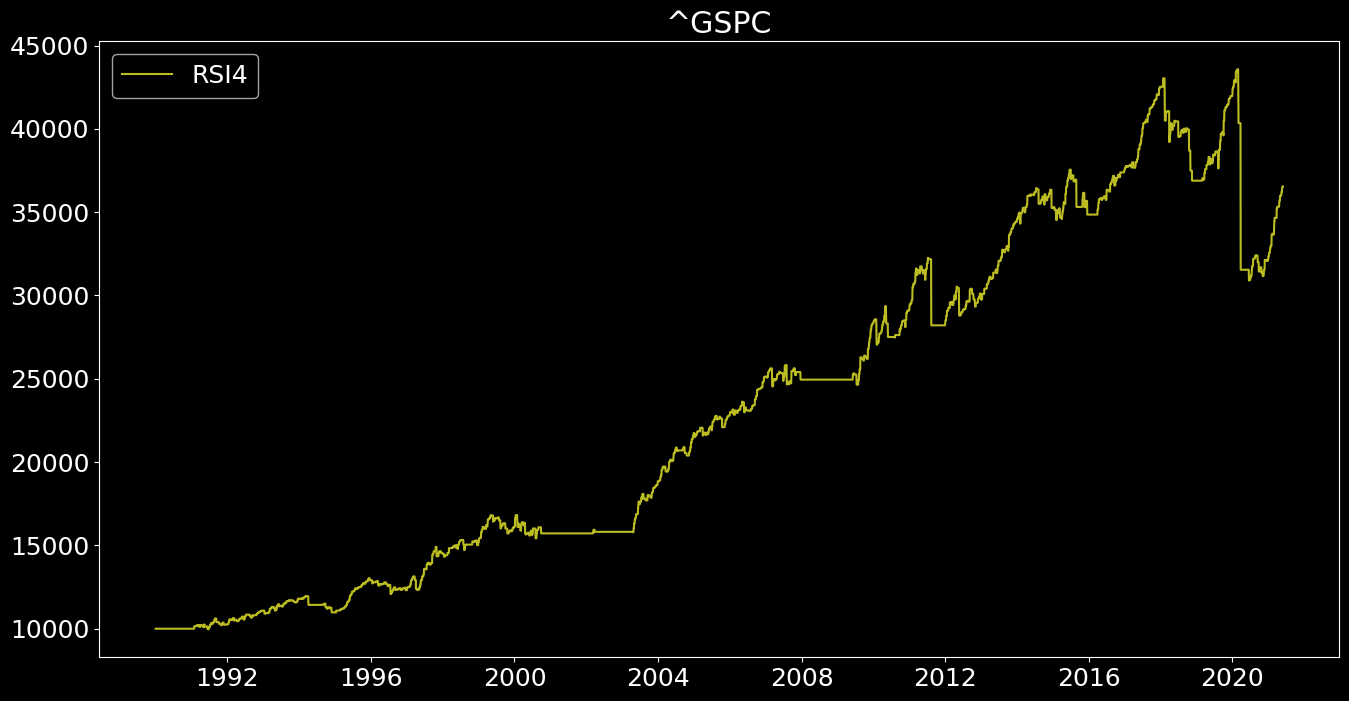

In [11]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange"]

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(sym)
    for c, s in enumerate(systems):
        plt.plot(results[count][f"{s}_Bal"], colours[c])

plt.legend(systems)
plt.show()

In [12]:
for m in full_metrics:
    print(m)
    print(full_metrics[m])

^GSPC
                          RSI4
Start_Balance         10000.00
Final_Balance         36544.20
Total_Return            265.44
Annual_Return             4.21
Time_in_Market           32.00
Return_By_Exposure       13.16
Max_Drawdown            -29.10
Return_Over_Drawdown      0.14
RBE_Over_Drawdown         0.45
Signals                2107.00
Trades                 2565.00
Gap                     129.00
No_Gap                 2436.00
Wins                    619.00
Losses                  254.00
Winrate                  70.90
Max_Trade_Return_pct      3.62
Max_Trade_Loss_pct      -21.81
Avg_Trade_Return_pct      0.70
Avg_Trade_Loss_pct       -1.16
Avg_RR                    0.60
